## Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
from pathlib import Path

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
sys.path.append('/home/k64835/Master-Thesis-SITS')

scripts_path = Path("../Data-Preprocessing/").resolve()
sys.path.append(str(scripts_path))

scripts_path = Path("../Evaluation/").resolve()
sys.path.append(str(scripts_path))

scripts_path = Path("../Modeling/").resolve()
sys.path.append(str(scripts_path))

In [21]:
import pickle
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from scripts.data_visualiser import *
import matplotlib.patches as mpatches
import torch.nn.functional as F
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from model_scripts.subpatch_extraction import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from model_scripts.model_helper import *
from model_scripts.dataset_creation import *
from model_scripts.train_model_ae import *
from model_scripts.model_visualiser import *
from model_scripts.clustering import *
from model_scripts.train_model_dcec import *
from evaluation_scripts.evaluation_helper import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
import numpy as np
import config as config
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skimage.measure
import torch
import torch.nn as nn
import torch.optim as optim

## Dataset prep: B10

### Loading the pre-processed data

Data: Extracted and Pre-processed Patches (each patch containing a sugarbeet field)

Dimensions: (N, T, C, H, W) = (N, 7, 10, 64, 64)

In [5]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers_train, acquisition_dates_train, patch_tensor_train, images_visualisation_train = preprocessing_pipeline.get_processed_temporal_cubes('train', 'allbands')
field_numbers_eval, acquisition_dates_eval, patch_tensor_eval, images_visualisation_eval = preprocessing_pipeline.get_processed_temporal_cubes('eval', 'allbands')
patch_tensor_train.shape, patch_tensor_eval.shape

(torch.Size([2425, 7, 10, 64, 64]), torch.Size([48, 7, 10, 64, 64]))

### Create Sub-Patches

In [6]:
train_subpatches, train_subpatch_coords = non_overlapping_sliding_window(patch_tensor_train, field_numbers_train, patch_size=config.subpatch_size)
eval_subpatches, eval_subpatch_coords = non_overlapping_sliding_window(patch_tensor_eval, field_numbers_eval, patch_size=config.subpatch_size)
train_subpatches.shape, eval_subpatches.shape

(torch.Size([39042, 7, 10, 5, 5]), torch.Size([867, 7, 10, 5, 5]))

Get field numbers and co-ordinates as string

In [7]:
train_coord_dataloader = get_string_fielddata(train_subpatch_coords)
eval_coord_dataloader = get_string_fielddata(eval_subpatch_coords)
train_coord_dataloader[0]

'1167134.0_25_25'

### Split Unlabeled data into 'train' and 'test' and create  Data Loaders

In [8]:
train_subpatches_dl, test_subpatches, train_field_numbers, test_field_numbers = train_test_split(
    train_subpatches, train_coord_dataloader, test_size=1-config.ae_train_test_ratio, random_state=42
)

dataloader_train = create_data_loader(train_subpatches_dl, train_field_numbers, batch_size=config.ae_batch_size, shuffle=True)
dataloader_test = create_data_loader(test_subpatches, test_field_numbers, batch_size=config.ae_batch_size, shuffle=False)
dataloader_eval = create_data_loader(eval_subpatches, eval_coord_dataloader, batch_size=config.ae_batch_size, shuffle=False)

/home/k64835/Master-Thesis-SITS/Modeling/model_scripts/dataset_creation.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).permute(0, 2, 1, 3, 4)   # (N, T, C, H, W) -> (N, C, T, H, W)


## Import trained Model

**Note:** Since we have defined our CNN_Model class in a .ipynb file and not a script(.py) file, we need to redfine the class here, and then we reload our model's state from the pickle file(.pkl) saved in trained-models folder

In [9]:
class Conv3DAutoencoder(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv3DAutoencoder, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels

        # --- Encoder (3D Convolutions) ---
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- 1D Convolution (Time Aggregation) ---
        self.conv1d = nn.Conv1d(256 * patch_size * patch_size, 256 * patch_size * patch_size, kernel_size=time_steps, stride=1, padding=0, groups=128 * patch_size * patch_size)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size, 512)   
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size)  

        # --- 1D Deconvolution to Expand Time Back ---
        self.deconv1d = nn.ConvTranspose1d(256 * patch_size * patch_size, 256 * patch_size * patch_size, kernel_size=time_steps, stride=1, padding=0, groups=128 * patch_size * patch_size)

        # --- 3D Deconvolutions ---
        self.unflatten = nn.Unflatten(1, (256, patch_size, patch_size))
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        
        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Reshape for 1D Conv ---
        b, c, t, h, w = x.shape  
        # print("x shape initial: ",x.shape)
        x = x.view(b, c * h * w, t)                     # (batch, 800, time)

        # print(f"Shape before 1D Conv: {x.shape}") 
        x = self.conv1d(x)                              # Time aggregation
        # print(f"Shape after 1D Conv: {x.shape}")      # (batch, 800, 1)

        # --- Flatten and Fully Connected ---
        x = self.flatten(x)  
        x = F.relu(self.fc1(x))
        z = self.fc2(x) 

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x)) 

        # --- Expand Time Back ---
        x = x.view(b, 6400, 1)  
        x = self.deconv1d(x) 
        # print(f"Shape after Deconv1D: {x.shape}")  # (batch, 800, time_steps)

        # --- Reshape for 3D Deconvolutions ---
        x = x.view(b, -1, self.time_steps, h, w)  
        # print("x before unflatten", x.shape)

        # --- 3D Deconvolutions ---
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)  

        return z, x_reconstructed


In [10]:
device = 'cuda'
latent_dim=32
channels = 10
time_steps = 7
patch_size = config.subpatch_size

trained_ae_model = Conv3DAutoencoder(channels, time_steps, latent_dim, config.subpatch_size)
device = torch.device(device)  
trained_ae_model.to(device)

Conv3DAutoencoder(
  (conv1): Conv3d(10, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv1d): Conv1d(6400, 6400, kernel_size=(7,), stride=(1,), groups=3200)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=6400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=6400, bias=True)
  (deconv1d): ConvTranspose1d(6400, 6400, kernel_size=(7,), stride=(1,), groups=3200)
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 5, 5))
  (deconv1): ConvTranspose3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv2): ConvTranspose3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (dec

Load checkpoints

In [11]:
with open(config.best_ae_b10_path, 'rb') as file:  
    trained_ae_model = pickle.load(file)

In [12]:
with open(config.best_ae_kmeans_b10_path, 'rb') as file:  
    trained_kmeans = pickle.load(file)

## Extract latent vectors for Visualization

Use trained Encoder part to get the features for train, test and evaluation Data

In [13]:
train_features, train_coord_dl = extract_features_ae(trained_ae_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_ae(trained_ae_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_ae(trained_ae_model, dataloader_eval, device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

In [14]:
cluster_train = trained_kmeans.predict(combined_train_features.numpy())
cluster_eval = trained_kmeans.predict(eval_features.numpy())

## TSNE: Train

In [15]:
all_points = np.vstack([combined_train_features, trained_kmeans.cluster_centers_])  # Stack data & centroids
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
all_points_2d = tsne.fit_transform(all_points)

# Separate transformed points
latent_2d_train = all_points_2d[:-trained_kmeans.n_clusters]  # First part: data points
centers_2d = all_points_2d[-trained_kmeans.n_clusters:]  # Second part: cluster centers

Plot

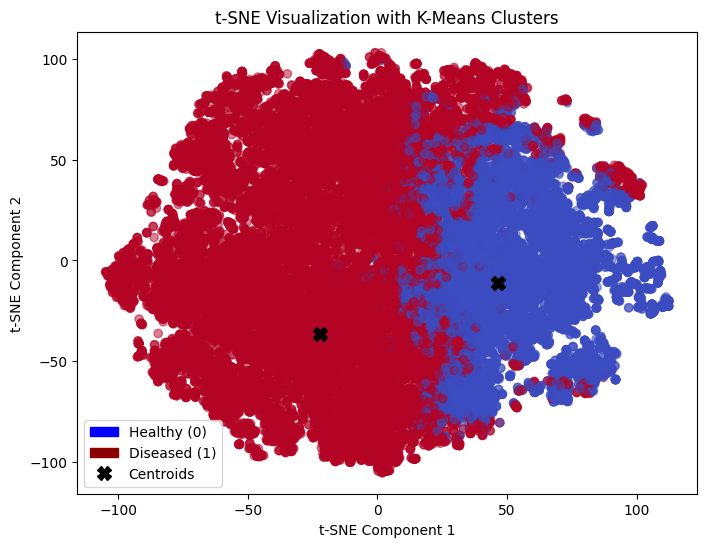

In [34]:
import matplotlib.lines as mlines


plt.figure(figsize=(8,6))
plt.scatter(latent_2d_train[:, 0], latent_2d_train[:, 1], c=cluster_train, cmap="coolwarm", alpha=0.5)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], color="black", marker="X", s=100, label="Centroids")
legend_labels = [mpatches.Patch(color='blue', label="Healthy (0)"),
                 mpatches.Patch(color='darkred', label="Diseased (1)"),
                 mlines.Line2D([], [], color="black", marker="X", linestyle="None", markersize=10, label="Centroids") ]
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization with K-Means Clusters")
plt.legend(handles=legend_labels)
plt.show()

### TSNE on Eval Data

TSNE to get 2D latent vectors for eval

In [17]:
eval_points = np.vstack([eval_features.numpy(), trained_kmeans.cluster_centers_])  
tsne_eval = TSNE(n_components=2, perplexity=30, random_state=42)
eval_points_2d = tsne_eval.fit_transform(eval_points)

# Separate transformed points
latent_2d_eval = eval_points_2d[:-trained_kmeans.n_clusters]  # First part: eval data points
centers_2d_eval = eval_points_2d[-trained_kmeans.n_clusters:]  # Last part: cluster centers

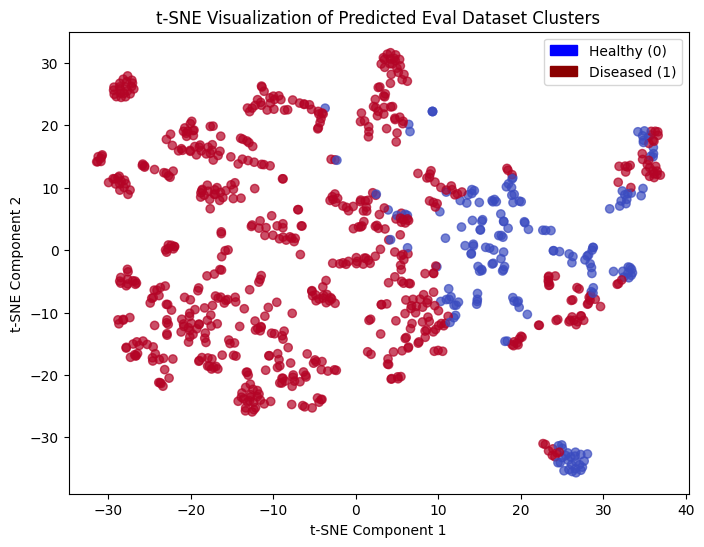

In [35]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_2d_eval[:, 0], latent_2d_eval[:, 1], c=cluster_eval, cmap="coolwarm", alpha=0.7, vmin=0, vmax=1)
legend_labels = [mpatches.Patch(color='blue', label="Healthy (0)"),
                 mpatches.Patch(color='darkred', label="Diseased (1)")]

plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of Predicted Eval Dataset Clusters")
plt.legend(handles=legend_labels)
plt.show()

### Eval Ground truth clusters -> But we cant assume that all sub-patches of a diseased field are diseased..

In [19]:
eval_field_numbers_cleaned = [str(int(float(num.split("_")[0]))) for num in eval_coord_dl]
eval_field_numbers_cleaned_unique = list(dict.fromkeys(eval_field_numbers_cleaned))

In [19]:
df_gt = pd.read_csv(config.labels_path, sep=';')
df_gt.columns = ["Number", "Disease"]
disease_mapping = {str(num): 1 if disease == "yes" else 0 for num, disease in zip(df_gt["Number"], df_gt["Disease"])}

In [48]:
ground_truth_labels = np.array([disease_mapping.get(num, -1) for num in eval_field_numbers_cleaned_unique])
ground_truth_labels

array([0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1])

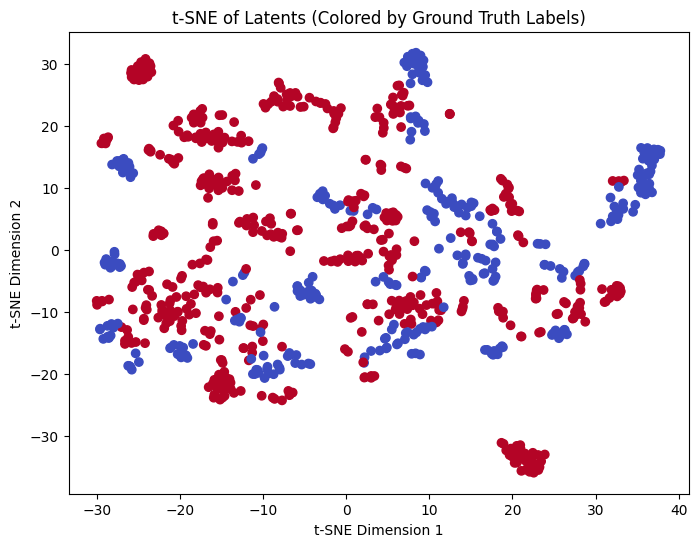

In [51]:
image_latents_flattened = eval_features.reshape(-1, eval_features.shape[-1])

tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(image_latents_flattened)
 
ground_truth_labels = np.array([
    disease_mapping.get(num, -1) for num in eval_field_numbers_cleaned_unique
])

label_map = {}
for idx, unique_field_num in enumerate(eval_field_numbers_cleaned_unique):
    label_map[unique_field_num] = ground_truth_labels[idx]

point_labels = [label_map[field_num] for field_num in eval_field_numbers_cleaned]


plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=point_labels, cmap='coolwarm')
plt.title('t-SNE of Latents (Colored by Ground Truth Labels)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

plt.show()
